# 📚 Notebook 6.2: Instructing Following Fine-tuning

🎉 Welcome back, fellow explorer! In our previous adventure, we dove into the world of fine-tuning the GPT-2 (124M) model to create a powerful text classifier. Today, we're taking things up a notch and embarking on a journey into **Instruct Fine-tuning (IF)**—a super exciting technique that enhances how our models understand and follow instructions! 🚀

<p align="center">
    <img src="images/if.png" alt="My Image" />
</p>

### What is Instruct Fine-tuning (IF)? 🤔

Instruct Fine-tuning (IF) is like giving our language model a special set of instructions to follow, making it even more adept at handling instruction-based tasks. By fine-tuning a pre-trained model on a dataset specifically designed for following commands, we can empower it to generate responses that align perfectly with what users ask for. Think of it as upgrading our trusty sidekick to become even more helpful! 🦸‍♂️✨

### Our Fun Plan 🎯

In this notebook, we’re going to have a blast following these steps:

1. **Prepare the data for IF fine-tuning**: Let’s get our dataset ready for the big training party! 🎉
2. **Load our previously built GPT model**: This time, we’re going for the **335M variant**—a powerful upgrade! 💪
3. **Fine-tune the model on the IF dataset**: Time to train our model to be the best instruction follower it can be! 📈
4. **Inspect the results**: After our training session, we’ll check out what our model has learned and how well it performs. 🔍
5. **Evaluate the model with Ollama**: Finally, we’ll put our model to the test using **Ollama** and see how it shines in the real world! 🌟

Let’s get started on this exciting journey! 🚀

## 1. Prepare the data for Instruction-following
We going to use a small dataset from the consist of 1100 data entries.

In [ ]:
# to get the data and load it we need : 
import os
import urllib.request
import json


In [7]:
import os
import urllib.request
import json

def download_and_load_data(file_path, url):
    # Check if the data file already exists
    if os.path.exists(file_path):
        print("Already exists... opening...")
        # If the file exists, open it and read the contents
        with open(file_path, 'r', encoding='utf-8') as f:
            text_data = f.read()
    else:
        print("Downloading...")
        # If the file does not exist, download the data from the provided URL
        with urllib.request.urlopen(url) as response:
            # Read and decode the response content
            text_data = response.read().decode('utf-8')
        # Save the downloaded data to the specified file path
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(text_data)

    # Load the JSON data directly from text_data
    # This converts the text representation of the JSON data into a Python object (list or dictionary)
    data = json.loads(text_data)
    return data

# Specify the file path for storing the data
file_path = "instruction-data.json"
# Define the URL to download the instruction data
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

# Call the function to download/load the data and store it in the 'data' variable
data = download_and_load_data(file_path, url)
# Print the number of entries in the loaded data
print("Number of entries:", len(data))
# Print an example entry from the list (entry at index 10)
print("Entry to the list:\n", data[10])


Downloading...
Number of entries: 1100
Entry to the list:
 {'instruction': 'What is the contraction for "will not"?', 'input': '', 'output': 'The contraction for "will not" is "won\'t".'}


Instruction fine-tuning involves retraining a language model on a dataset where each entry is structured as an **input-output pair**. Typically, this data is extracted from a **JSON format**. By training on this data, the model learns to generate responses that align with specific instructions or contexts.

### Data Formatting Methods

To effectively format this data for instruction fine-tuning, we can use two primary prompting methods:

1. **Alpaca Style Format**
   - This format is designed to provide clear structure to the input-output pairs.
   - **Template Structure**:
     ```
     ## Instruction
     <Instruction goes here>
     
     ## Input
     <Input data here>
     
     ## Response
     <Expected output here>
     ```

2. **Phi3 Format**
   - This approach employs a conversational style, framing the interaction in a user-assistant dialogue.
   - **Template Structure**:
     ```
     ## <|user|>
     <User input goes here>
     
     ## <|assistant|>
     <Expected response from the assistant>
     ```

### Summary of Differences

| Feature               | Alpaca Style Format                      | Phi3 Format                               |
|-----------------------|------------------------------------------|-------------------------------------------|
| **Structure**         | Clear sections for instruction, input, and response | Conversational dialogue between user and assistant |
| **Clarity**           | Highly structured, easy to follow       | More fluid, encourages natural interactions |
| **Use Cases**         | Ideal for straightforward tasks         | Suitable for interactive and engaging responses |


## Here we choosing Alpaca 


In [8]:
def format_input(entry):
    # Create the instruction text using the instruction from the entry
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"  # Include the instruction in the formatted text
    )

    # Check if the input exists; if so, format it accordingly
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    # Combine the instruction text and input text (if any) and return the result
    return instruction_text + input_text


In [9]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


## Now lets move to split the data 
We can use sklearn train_test_split 

In [10]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(data, test_size=0.15, random_state=42)  # 85% train, 15% temp

# Split temp data into 5% validation and 10% test
val_data, test_data = train_test_split(temp_data, test_size=(10/15), random_state=42)  # 5% val, 10% test

print("Train data size:", len(train_data))
print("Validation data size:", len(val_data))
print("Test data size:", len(test_data))

Train data size: 935
Validation data size: 55
Test data size: 110


Creating the initial state of dataset , as we need to add modification to suit the instruction fine tuning format

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        # Initialize the dataset with data and a tokenizer
        self.data = data
        self.encode_data = []

        # Loop through each entry in the dataset
        for entry in data:
            # Format the input entry into a structured text
            instruction_text = format_input(entry) ## using the function defined above
            # Prepare the desired response format
            desired_response = f"\n\n### Response:\n{entry['output']}"
            # Combine instruction and response into full text
            full_text = instruction_text + desired_response
            # Encode the full text using the provided tokenizer and store it
            self.encode_data.append(
                tokenizer.encode(full_text)
            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.encode_data[index]


Moving to the Key Aspect of Data Preprocessing: Batch Processing
In the previous notebook, we allowed the PyTorch Dataset to handle the batching automatically. However, in this scenario, we need to take a more hands-on approach. We will create a custom function to facilitate batching in our dataset class.

Let’s walk through the process step by step:

Choosing the Longest Sequence in the Batch:
The longest sequence in the batch will serve as the standard length.
All other sequences in the batch will be padded to match this length.
By implementing this method, we can ensure that our input data is consistently formatted for processing in the model.

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special = {"<|endoftext|>"}))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.3 MB/s eta 0:00:00
[50256]


In [ ]:

def collate_fn1(batch, pad_token_id=50256, device="cpu"):
    """
    Custom collate function to prepare batches for training.
    
    Args:
        batch (list): A list of input sequences to be processed.
        pad_token_id (int): The token ID used for padding sequences (default: 50256).
        device (str): The device to which the tensors will be moved (default: "cpu").
    
    Returns:
        torch.Tensor: A tensor containing padded input sequences.
    """
    
    # Determine the maximum length of sequences in the current batch
    batch_max_length = max(len(entry) + 1 for entry in batch)  # +1 for the additional padding

    # Initialize a list to hold the processed input tensors
    input_ls = []

    # Iterate through each entry in the batch
    for entry in batch:
        # Create a copy of the current entry
        new_entry = entry.copy()
        
        # Append the padding token to the end of the current entry
        new_entry += [pad_token_id]

        # Pad the current entry with the pad token until it matches the maximum length
        padded = (
            new_entry + [pad_token_id] * (batch_max_length - len(new_entry))
        )
        
        # Convert the padded list to a tensor, excluding the last padding token (used for sequence modeling)
        inputs = torch.tensor(padded[:-1])
        
        # Add the input tensor to the list of input tensors
        input_ls.append(inputs)

    # Stack the list of tensors into a single tensor and move it to the specified device
    inputrs_tensor = torch.stack(input_ls).to(device)
    
    # Return the resulting tensor containing the padded input sequences
    return inputrs_tensor


Lets test the function to examine the output 

In [10]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(collate_fn1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In the batching process, we identify `input_1` as the longest tensor in the batch. To ensure uniformity, we pad shorter tensors using the `<|endoftext|>` token added to the tokenizer.

### Key Points:
1. **Longest Tensor**: We determine the maximum length of tensors in the batch.
2. **Padding**: Each tensor is padded with `(len(max_length) - len(the tensor))` instances of the padding token until all tensors match the maximum length.


In [11]:
inputs_1 = [0, 1, 2, 3, 4,7,10]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(collate_fn1(batch))

tensor([[    0,     1,     2,     3,     4,     7,    10],
        [    5,     6, 50256, 50256, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256, 50256, 50256]])


### Padding the Target Tensor

The second step involves padding the target tensor. We use the same padding method as before, but with a slight adjustment in the slicing:

1. **Padding Logic**: Each target tensor is padded to match the maximum length, similar to the input tensors.
2. **Slicing Adjustment**: The key difference is that we slice the input tensor with `input + 1`. This is necessary for the autoregressive generation, where the target should include the next token after the input.

### Example:
- If the input tensor is `[token1, token2, token3]` (length 3), the target tensor would look like:
  - **Input**: `[token1, token2, token3]` → **Max Length**: 4
  - **Target**: `[token2, token3, <|endoftext|>]` (length 3, padded with 1 `<|endoftext|>` token)

lets implement this in the second veriosn of the function

In [ ]:
def collate_fn2(batch, pad_token_id=50256, device="cpu"):
    # Determine the maximum length of the input sequences in the batch
    batch_max_length = max(len(item) + 1 for item in batch)
    
    # Initialize lists to hold input and target tensors
    input_ls, target_lst = [], []

    # Iterate over each item in the batch
    for item in batch:
        # Create a copy of the current item and append the padding token
        new_item = item.copy()
        new_item += [pad_token_id]  # Append pad token to the end

        # Pad the input sequence to match the maximum length
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )

        # Create the input tensor by excluding the last token
        inputs = torch.tensor(padded[:-1])  # All but the last token
        # Create the target tensor by excluding the first token
        target = torch.tensor(padded[1:])  # All but the first token

        # Append the input and target tensors to their respective lists
        input_ls.append(inputs)
        target_lst.append(target)

    # Stack the input and target lists into tensors and move them to the specified device
    input_tensor = torch.stack(input_ls).to(device)
    target_tensor = torch.stack(target_lst).to(device)
    
    return input_tensor, target_tensor  # Return both tensors


Lets see the result of the implementaion 

In [13]:
inputs_1 = [0, 1, 2, 3, 4,7,10]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

input_tensor, target_tensor = collate_fn2(batch)
print("input tensor",input_tensor)
print("target tensor:",target_tensor)

input tensor tensor([[    0,     1,     2,     3,     4,     7,    10],
        [    5,     6, 50256, 50256, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256, 50256, 50256]])
target tensor: tensor([[    1,     2,     3,     4,     7,    10, 50256],
        [    6, 50256, 50256, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256, 50256, 50256]])


### Third Step: Masking the Target Tensor Padding

In this step, we mask the padding in the target tensor, except for the first `|<endoftext>|` token. This is essential for the following reasons:

1. **Preventing Loss Calculation Errors**:  
   We want to avoid including irrelevant data (like padding tokens) in the loss calculation. Including padding would skew the model's training, as the model would be penalized for generating predictions against these non-informative tokens.

2. **Preserving the End-of-Text Token**:  
   The first padding token is retained because it corresponds to the `|<endoftext>|` token. This token is crucial for language modeling, as it helps the model understand when a piece of text has ended. Losing this context could hinder the model's ability to predict the termination of a sequence accurately.

By masking appropriately, we ensure that the model focuses on the meaningful parts of the data while still recognizing the importance of the end-of-text marker.


In [ ]:
def collate_fn3(batch, pad_token_id=50256, ignore_index=-100, allowed_max_len=None, device="cpu"):
    # Determine the maximum length of the sequences in the batch
    batch_max_length = max(len(item) + 1 for item in batch)
    input_ls, target_ls = [], []

    # Iterate through each item in the batch
    for item in batch:
        # Create a copy of the item and append the padding token
        new_item = item.copy()
        new_item += [pad_token_id]

        # Pad the item to the maximum length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))

        # Separate inputs and targets; inputs exclude the last token, targets exclude the first token
        inputs = torch.tensor(padded[:-1])  # Input tensor
        target = torch.tensor(padded[1:])   # Target tensor

        # Create a mask for the padding tokens in the target tensor
        mask = target == pad_token_id
        indices = torch.nonzero(mask).squeeze()  # Get indices of padding tokens

        # If there are multiple padding tokens, ignore the subsequent ones in the loss calculation
        if indices.numel() > 1:
            target[indices[1:]] = ignore_index  # Set ignore index for padding

        # Optionally limit the length of inputs and targets
        if allowed_max_len is not None:
            inputs = inputs[:allowed_max_len]
            target = target[:allowed_max_len]

        # Append the processed inputs and targets to the respective lists
        input_ls.append(inputs)
        target_ls.append(target)

    # Stack the lists into tensors and move them to the specified device
    input_tensor = torch.stack(input_ls).to(device)
    target_tensor = torch.stack(target_ls).to(device)

    return input_tensor, target_tensor  # Return the batched input and target tensors


Notice the target tensor masking

In [15]:
inputs, targets = collate_fn3(batch)
print("input tensor:",inputs)
print("\ntarget tensor:",targets)

input tensor: tensor([[    0,     1,     2,     3,     4,     7,    10],
        [    5,     6, 50256, 50256, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256, 50256, 50256]])

target tensor: tensor([[    1,     2,     3,     4,     7,    10, 50256],
        [    6, 50256,  -100,  -100,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100,  -100,  -100]])


### Why We Mask Using -100
We use `-100` for masking in PyTorch because it is the default ignore index. When PyTorch encounters this value during loss calculation, it automatically ignores it. As a result, no effect will occur in the loss calculation for these masked tokens.

lets examone this hands on with the foloowing example notce we happen in loss_1 , loss_2 and 3 

In [16]:
logits_1 = torch.tensor(
                        [[-1.0, 1.0],
                        [-0.5, 1.5]])

target_1 = torch.tensor([0, 1])

loss_1 = torch.nn.CrossEntropyLoss()

#
print(loss_1(logits_1, target_1))

tensor(1.1269)


In [17]:
logits_2 = torch.tensor(
                      [[-1.0, 1.0],
                      [-0.5, 1.5],
                      [-0.5, 1.5]])

targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.CrossEntropyLoss()

#
print(loss_2(logits_2, targets_2))
#


tensor(0.7936)


In [18]:
targets_2 = torch.tensor([0, 1, -100])

print(loss_2(logits_2, targets_2))

tensor(1.1269)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Plugging the Custom Function into Our Dataset

Now that we have defined our custom collate functions, we are ready to integrate them into our dataset. To do this, we can use the `partial` function from the `functools` standard library. This allows us to create a version of the collate function that pre-fills certain arguments, making it easier to manage our data processing within the DataLoader.

Here's how we can implement this:


In [20]:
from functools import partial

custom_collate_fn = partial(collate_fn3,
                            device=device,
                            allowed_max_len=1024)

num_workers = 0
batch_size = 4

train_dataset = InstructionDataset(train_data, tokenizer)
val_dataset = InstructionDataset(val_data, tokenizer)
test_dataset = InstructionDataset(test_data, tokenizer)

train_dataloader = DataLoader(
    train_dataset,
    collate_fn=custom_collate_fn,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataloader = DataLoader(
    val_dataset,
    collate_fn=custom_collate_fn,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=num_workers
)

test_dataloader = DataLoader(
    test_dataset,
    collate_fn=custom_collate_fn,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=num_workers
)

print("Train dataloader:", len(train_dataloader))
print("Validation dataloader:", len(val_dataloader))
print("Test dataloader:", len(test_dataloader))

Train dataloader: 233
Validation dataloader: 13
Test dataloader: 27


### Unified Batch Size with Variable Tensor Dimensions

It is important to note that while the batch size remains unified across the dataset, the other dimensions of the tensors can vary. This variability arises from the preprocessing steps we implemented, which are specifically tailored for instruction fine-tuning.

This preprocessing approach is crucial for instruction fine-tuning because:
- It allows the model to handle varying lengths of text inputs effectively, which is common in natural language tasks.
- It ensures that the model retains relevant context while ignoring non-informative padding tokens during training.

By implementing these preprocessing steps, we optimize our dataset for instruction fine-tuning, enabling the model to learn more effectively from diverse input lengths while maintaining a consistent batch size.


In [21]:
print("val Loader:")
for input , target in val_dataloader:
    print(input.shape , target.shape)

print("Batch size in val_dataloader:", val_dataloader.batch_size)


val Loader:
torch.Size([4, 83]) torch.Size([4, 83])
torch.Size([4, 50]) torch.Size([4, 50])
torch.Size([4, 72]) torch.Size([4, 72])
torch.Size([4, 68]) torch.Size([4, 68])
torch.Size([4, 64]) torch.Size([4, 64])
torch.Size([4, 60]) torch.Size([4, 60])
torch.Size([4, 66]) torch.Size([4, 66])
torch.Size([4, 68]) torch.Size([4, 68])
torch.Size([4, 53]) torch.Size([4, 53])
torch.Size([4, 73]) torch.Size([4, 73])
torch.Size([4, 67]) torch.Size([4, 67])
torch.Size([4, 64]) torch.Size([4, 64])
torch.Size([4, 58]) torch.Size([4, 58])
Batch size in val_dataloader: 4


## 2. Loading the Pre-trained Model

Now that we’ve completed data processing, we can move on to preparing the model and loading pre-trained weights. In this step, we'll apply a different variant of GPT-2—specifically, the 335M parameter model—contrasting with the 124M model used in previous notebooks.

### Why the 335M Model?

- **Lighter Models for Simpler Tasks**:  
  In prior tasks, we used the 124M GPT-2 model due to its smaller size, making it faster for training and more efficient for tasks like basic classification fine-tuning.

- **More Demanding Tasks**:  
  For this instruction fine-tuning, which is more complex and computationally demanding, we’re opting for the 335M model. This larger model size enables it to handle more nuanced tasks with greater contextual understanding.

### Scalability

One of the benefits of our approach is scalability. This setup allows for easily switching to larger models (e.g., GPT-2 XL) without extensive reconfiguration—only minor modifications to the configuration are needed. This flexibility makes it straightforward to experiment with models of varying sizes to fit specific use cases.


In [ ]:
from UTILS.model import GPTModel 
from UTILS.load_weights import download_and_load_gpt2 , load_weights_into_gpt , text_to_tokens_ids, token_ids_to_text 
from UTILS.finetune_utils import trainerV1

# Base configuration for GPT-2 model
BASE_CONFIG = {
    "vocab_size": 50257,       # Vocabulary size
    "context_length": 1024,     # Context length for the model
    "drop_rate": 0.0,           # Dropout rate
    "qkv_bias": True            # Bias term in query-key-value mechanism
}

# Different configurations for GPT-2 model variants
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Select the model variant
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])  # Update base config with selected model's settings

# Extract model size for downloading parameters
model_size = CHOOSE_MODEL.split(" ")[-1].strip("()")

# Download and load model parameters
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

# Initialize the model and load weights
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()  # Set model to evaluation mode


File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

## 3. Fine-Tuning the Model for Instruction Following

The process of fine-tuning our model for instruction-following shares many similarities with the standard training process, as detailed in previous notebooks. For this task, we will reuse key components from our previous implementations, including:

1. Generation Functions**  
   These will help us monitor the training process and assess model performance.

2. **Training Loop (TrainerV1)**  
   Given that we intend to train for only a small number of epochs, we’re opting for a straightforward training loop (TrainerV1). This simplified approach is effective for quick fine-tuning. For more complex tasks, like training a model from scratch, a more advanced training loop would be necessary to stabilize the process using advanced techniques.

This efficient setup allows us to focus on the essentials without overcomplicating the fine-tuning process.


Now lets train the model for couple epochs :

<p align="center">
    <img src="images/gpu_table.png" alt="My Image" />
</p>

In [28]:
# Note:
# Uncomment the following code to calculate the execution time
import time

# Start the timer to measure execution time
start_time = time.time()

# Set device to GPU if available; otherwise, use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set a manual seed for reproducibility
torch.manual_seed(123)

# Initialize the model and move it to the specified device
model.to(device)

# Set up the AdamW optimizer with specified learning rate and weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)

# Initialize the tokenizer for encoding and decoding text
tok = tiktoken.encoding_for_model("gpt2")

# Define the number of epochs for training
num_epochs = 2

# Call the training function and store the resulting losses and tokens seen
train_losses1, val_losses1, tokens_seen1 = trainerV1(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,  # Evaluate every 5 steps
    eval_iter=5,  # Use 5 batches for evaluation
    start_context=format_input(val_data[0]),  # Initial context for text generation
    tokenizer=tok  # Tokenizer for text processing
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()

# Calculate the total execution time in minutes
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Step 000000): Train loss 4.062, Val loss 4.065
Ep 1 (Step 000005): Train loss 1.439, Val loss 1.552
Ep 1 (Step 000010): Train loss 1.254, Val loss 1.261
Ep 1 (Step 000015): Train loss 0.947, Val loss 1.140
Ep 1 (Step 000020): Train loss 0.990, Val loss 1.138
Ep 1 (Step 000025): Train loss 1.353, Val loss 1.279
Ep 1 (Step 000030): Train loss 1.217, Val loss 1.294
Ep 1 (Step 000035): Train loss 0.903, Val loss 1.150
Ep 1 (Step 000040): Train loss 0.861, Val loss 1.115
Ep 1 (Step 000045): Train loss 1.132, Val loss 1.116
Ep 1 (Step 000050): Train loss 0.823, Val loss 1.132
Ep 1 (Step 000055): Train loss 0.946, Val loss 1.070
Ep 1 (Step 000060): Train loss 0.712, Val loss 1.041
Ep 1 (Step 000065): Train loss 0.956, Val loss 0.987
Ep 1 (Step 000070): Train loss 0.820, Val loss 0.993
Ep 1 (Step 000075): Train loss 0.807, Val loss 1.005
Ep 1 (Step 000080): Train loss 0.660, Val loss 1.003
Ep 1 (Step 000085): Train loss 0.636, Val loss 1.017
Ep 1 (Step 000090): Train loss 0.949, Val loss

The training output shows that the model is learning effectively, as we can tell based
on the consistently decreasing training and validation loss values over the two epochs.
This result suggests that the model is gradually improving its ability to understand and
follow the provided instructions

In [ ]:

# Save the model's state dictionary
torch.save(model.state_dict(), 'model_weights.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Observing Epoch Impact on Instruction Fine-Tuning

In practice, I’ve found that training for a large number of epochs is often unnecessary and can even diminish results due to overfitting or other issues. Surprising? Let’s put this to the test by training for just two additional epochs and comparing the results. 

If my observations hold true, we should see:

1. **Minimal improvement** (or possibly none) in model performance.
2. **Potential decline** in the model’s ability to generalize well.

Let’s run the training for two more epochs and analyze the outcome.

In [30]:
num_epochs = 2

# Call the training function and store the resulting losses and tokens seen
train_losses2, val_losses2, tokens_seen2 = trainerV1(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,  # Evaluate every 5 steps
    eval_iter=5,  # Use 5 batches for evaluation
    start_context=format_input(val_data[0]),  # Initial context for text generation
    tokenizer=tok  # Tokenizer for text processing
)

Ep 1 (Step 000000): Train loss 0.341, Val loss 1.017
Ep 1 (Step 000005): Train loss 0.382, Val loss 1.048
Ep 1 (Step 000010): Train loss 0.401, Val loss 1.045
Ep 1 (Step 000015): Train loss 0.265, Val loss 1.075
Ep 1 (Step 000020): Train loss 0.358, Val loss 1.115
Ep 1 (Step 000025): Train loss 0.364, Val loss 1.138
Ep 1 (Step 000030): Train loss 0.342, Val loss 1.079
Ep 1 (Step 000035): Train loss 0.317, Val loss 1.073
Ep 1 (Step 000040): Train loss 0.361, Val loss 1.090
Ep 1 (Step 000045): Train loss 0.315, Val loss 1.106
Ep 1 (Step 000050): Train loss 0.299, Val loss 1.084
Ep 1 (Step 000055): Train loss 0.366, Val loss 1.071
Ep 1 (Step 000060): Train loss 0.301, Val loss 1.082
Ep 1 (Step 000065): Train loss 0.330, Val loss 1.078
Ep 1 (Step 000070): Train loss 0.310, Val loss 1.083
Ep 1 (Step 000075): Train loss 0.311, Val loss 1.072
Ep 1 (Step 000080): Train loss 0.316, Val loss 1.071
Ep 1 (Step 000085): Train loss 0.342, Val loss 1.056
Ep 1 (Step 000090): Train loss 0.340, Val loss

Plotting the result for better observation  

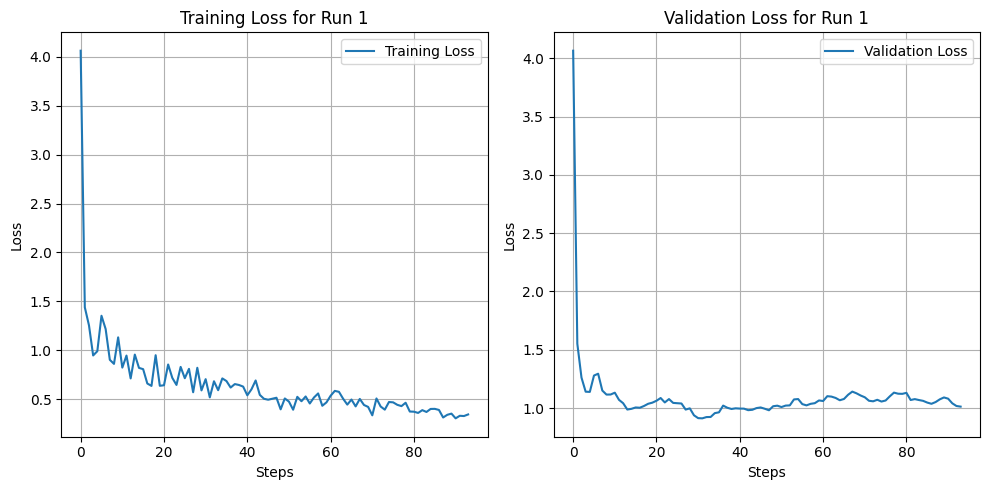

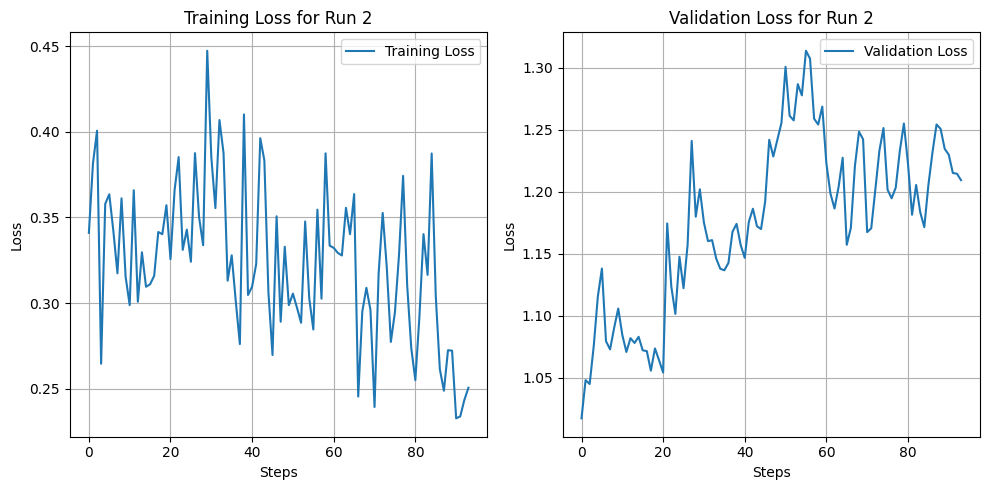

In [31]:
import matplotlib.pyplot as plt

# Function to plot training and validation losses
def plot_losses(train_losses, val_losses, run_number):
    plt.figure(figsize=(10, 5))

    # Plotting training losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title(f'Training Loss for Run {run_number}')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plotting validation losses
    plt.subplot(1, 2, 2)
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Validation Loss for Run {run_number}')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Plot losses for the first run
plot_losses(train_losses1, val_losses1, run_number=1)

# Plot losses for the second run
plot_losses(train_losses2, val_losses2, run_number=2)

## Lets us the new model to generate text using our text_data sample

In [75]:
model = GPTModel(BASE_CONFIG)
model.to(device)   # Move to the correct device if necessary

# Load the saved state dictionary
model.load_state_dict(torch.load('model_weights.pth'))

# Set the model to evaluation mode
model.eval()

model
torch.manual_seed(123)
for entry in test_data[:5]:
    input_text = format_input(entry)

    # Generate token IDs
    token_ids = generate(
        model=model,
        idx=text_to_tokens_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    # Convert token IDs back to text
    generated_text = token_ids_to_text(token_ids, tokenizer)

    # Extract response text after the prompt
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print("Input text:", input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")


<ipython-input-75-0b9df379f9cb>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))


Input text: Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite this statement as an imperative sentence.

### Input:
You should finish your assignment.

Correct response:
>> Finish your assignment.

Model response:
>> You should finish your assignment.
-------------------------------------
Input text: Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the adjective in the sentence.

### Input:
The quick fox jumped over the lazy dog.

Correct response:
>> The adjectives in the sentence are 'quick' and 'lazy'.

Model response:
>> The adjective in the sentence is 'jumps over the lazy dog.'
-------------------------------------
Input text: Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert 12 meters to centimeters.

Correct response:
>> 12 meters is 

## 4 - Model Evaluation

While decreasing loss is a promising sign, it isn’t sufficient alone to fully judge the model’s effectiveness—especially for tasks as complex as instruction following. This isn't a simple text classification problem with an easily measurable accuracy score, and reviewing all test data is often impractical, especially with production-level datasets. 

### Common Evaluation Approaches for Instruction-Fine-Tuned LLMs

In practice, instruction-following models like chatbots are often evaluated through multiple methods to capture a more holistic view of their performance. Here are three main approaches:

1. **Short-Answer and Multiple-Choice Benchmarks**  
   Benchmarks like *Measuring Massive Multitask Language Understanding (MMLU)* test the model’s general knowledge and ability to perform well across a variety of topics. MMLU, for example, is a widely recognized benchmark for evaluating language models' ability to generalize across diverse subjects [MMLU](https://arxiv.org/abs/2009.03300).

2. **Human Preference Comparisons**  
   Platforms like the *LMSYS Chatbot Arena* provide human preference comparisons. These allow users or reviewers to directly compare the model's responses to those of other language models, providing insights into how well the model performs in real-world conversational contexts. See [LMSYS Chatbot Arena](https://arena.lmsys.org) for more details.

3. **Automated Conversational Benchmarks**  
   Another common practice is to have a high-level model, such as GPT-4, evaluate the responses generated by the fine-tuned model. This automated evaluation offers a scalable way to get feedback, ensuring consistency in criteria and insights, particularly when human evaluations are infeasible.

By combining these evaluation methods, we gain a more reliable and nuanced understanding of the model’s performance, especially in complex applications such as instruction following and dialogue. This can guide us in making informed adjustments and improvements, ensuring the model meets quality expectations.

### Evaluation with Custom LLM-Assisted Approach

To evaluate our fine-tuned model's responses, we’ll use an approach similar to AlpacaEval by having another LLM review the generated outputs. Unlike public benchmarks, we’ll use a custom test set tailored to our specific use cases. This allows us to assess the model’s effectiveness directly within our intended application areas, as represented in our instruction dataset.

For each input in our test set, we use the model's `generate` method to produce responses. These responses are then appended to the `test_set` dictionary, which allows us to track both the input prompts and model outputs. This structured format makes it straightforward to evaluate each response later.  
To facilitate later analysis, we save the updated `test_set` data as `"instruction-data-with-response.json"`. This record not only preserves the outputs but also provides a convenient way to reload and review responses in other sessions.





In [28]:
from tqdm import tqdm
from UTILS.finetune_utils import generate , generate_text_simple
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
for i,entry in tqdm(enumerate(test_data),total =len(test_data)):
  input_text = format_input(entry)
  token_ids = generate(
      model = model ,
      idx = text_to_tokens_ids(input_text , tokenizer).to(device),
      max_new_tokens = 256,
      context_size = BASE_CONFIG["context_length"],
      eos_id = 50256
  )

  gen_text = token_ids_to_text(token_ids, tokenizer)

  response_text = (gen_text[len(input_text):].replace("### Response:", "").strip())

  test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file :
  json.dump(test_data, file, indent=4)



100%|██████████| 110/110 [35:31<00:00, 19.38s/it]


In [29]:
print(test_data[2])

{'instruction': 'Convert 12 meters to centimeters.', 'input': '', 'output': '12 meters is 1200 centimeters.', 'model_response': '12 meters is equal to 1 centimeters.'}


**Ollama: Efficient Inference on Laptops**

Ollama is an application optimized for running large language models (LLMs) on laptops by using `llama.cpp`, an open-source library written in pure C/C++. This focus on C/C++ allows for highly efficient inference, enabling users to generate text with LLMs even on less powerful hardware like laptops. 

While Ollama is effective for inference (text generation), it's designed solely for this purpose. It does not support training or fine-tuning LLMs, meaning users looking to adjust model weights or train new models will need to use other tools.

## Installing and Running Ollama

To use Ollama effectively, follow these setup steps based on your operating system.

1. **Download and Install Ollama**  
   - Visit [https://ollama.com](https://ollama.com) and follow the download instructions for your OS.
   - **macOS & Windows**: Open the downloaded Ollama application, and if prompted, allow installation of command-line tools.
   - **Linux**: Use the installation command provided on the Ollama website.

2. **Running Ollama**  
   Once installed, Ollama is ready to run language models through your command line interface:
   ```bash
   ollama run llama3.2
   ```
   or
   ```bash
   ollama run llama3
   ```
   Choose the model that best suits your hardware; the model will be downloaded on the first run.

3. **Ensuring Ollama Stays Active**  
   Make sure Ollama is in "run" mode so you can continue uninterrupted. You can use one of the following commands to keep it running:
   ```bash
   ollama serve
   ```
   This way, Ollama continues running in the background, allowing you to interact with it seamlessly throughout your session.

   <p align="center">
       <img src="images/ollama.png" alt="Ollama in Action" />
   </p>

Now, you’re ready to run LLMs efficiently on your laptop with Ollama.

## You can make sure the session is working with the following code : 

In [42]:
import psutil
def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break

    return running
ollama_running = check_if_running("ollama")
if not ollama_running:
    raise RuntimeError(
"Ollama not running. Launch ollama before proceeding."
)
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


# Querying Ollama's Local Model

In this section, we define a function `query_model` that interacts with a locally running instance of the Ollama model API. The function sends a prompt to the specified model and retrieves a response, which can be used for various tasks such as scoring or evaluating model outputs. 

## Function Breakdown

- **Function Definition**: The `query_model` function accepts three parameters:
  - `prompt`: The text prompt we want to send to the model for generating a response.
  - `model`: The name of the model to be queried (default is set to "llama3.2").
  - `url`: The API endpoint for the model (default is set to "http://localhost:11434/api/chat").

- **Data Preparation**: 
  - The function prepares a JSON payload that includes the model name, the user prompt, and options for generating the response. Options like `seed`, `temperature`, and `num_ctx` can be adjusted to control the randomness and context size of the model's responses.

- **Making the Request**: 
  - The JSON payload is converted to bytes and sent to the specified URL using a POST request. The `Content-Type` header is set to `application/json` to indicate the format of the request.

- **Response Handling**: 
  - The function reads the response from the API line by line and accumulates the response content until the end of the response is reached.

- **Return Value**: The final accumulated response is returned as a string, which can be further processed or analyzed.



In [ ]:
# Define the function to query Ollama's local model
def query_model(prompt, model="llama3.2", url="http://localhost:11434/api/chat"):
    # Prepare the data payload for the API request
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,            # For deterministic responses
            "temperature": 0,
            "num_ctx": 2048
        }
    }
    
    # Convert data payload to JSON and encode it
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")
    
    response_data = ""
    # Make the request to the API and handle the response
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    
    return response_data




In [47]:
for entry in test_data[:10]:
    # Prepare the prompt for scoring
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}` "
        f"on a scale from 0 to 100, where 100 is the best score."
    )
    
    # Print the original dataset response
    print("\nDataset response:")
    print(">>", entry['output'])
    
    # Print the model's response
    print("\nModel response:")
    print(">>", entry["model_response"])
    
    # Print the score given by the model
    print("\nScore:")
    print(">>", query_model(prompt))
    
    print("\n-------------------------")



Dataset response:
>> Finish your assignment.

Model response:
>> You should finish your assignment.

Score:
>> ### Corrected Response:
The corrected response is: "Finish your assignment."

### Score: 100

Explanation: The original response "You should finish your assignment." is already in the imperative form, which means it is a command or instruction. Therefore, no changes are needed to rewrite it as an imperative sentence. It meets the criteria for a perfect score because it accurately conveys the intended meaning and is grammatically correct.

-------------------------

Dataset response:
>> The adjectives in the sentence are 'quick' and 'lazy'.

Model response:
>> The adjective in the sentence is 'jumps over the lazy dog.'

Score:
>> ### Response:
The adjectives in the sentence are 'quick' and 'lazy'.

### Score: 100

Explanation:

* The response correctly identifies the two adjectives in the sentence.
* It uses the correct grammatical form ("adjectives" instead of "adjective") to

# Model Scoring Function

In this section, we define the `generate_model_scores` function, which takes a JSON dataset and evaluates the model's responses based on a specified key. The function constructs prompts to score the responses on a scale from 0 to 100 using a local model (in this case, `llama3`). The scores are collected in a list and returned at the end of the function. 

The function operates as follows:
1. It iterates through each entry in the provided JSON data.
2. For each entry, it constructs a prompt that includes the input, the correct output, and the model's response.
3. It calls the `query_model` function to get a score for the model's response.
4. The score is appended to a list, which is returned after processing all entries.
5. If a score cannot be converted to an integer, it logs an error message.

This process helps us quantitatively assess the model's performance based on predefined inputs and outputs.


In [51]:
def generate_model_scores(json_data, json_key, model="llama3.2"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}` "
            f"on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model) 
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue
    return scores


In [52]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:   1%|          | 1/110 [00:14<26:17, 14.47s/it]

Could not convert score: Score: 80


Scoring entries:   4%|▎         | 4/110 [01:07<31:41, 17.94s/it]

Could not convert score: I'd classify it as follows:

Vegetables: Broccoli
Metals: Iron
Animals: Elephant

Score: 0


Scoring entries:   9%|▉         | 10/110 [02:48<30:29, 18.29s/it]

Could not convert score: 70

The classification of the sentence 'Exclamation.' is not provided as it's incomplete and doesn't follow the instruction format.


Scoring entries:  14%|█▎        | 15/110 [04:12<27:54, 17.62s/it]

Could not convert score: 90

He will be reading a novel inspired by his grandmother.


Scoring entries:  23%|██▎       | 25/110 [06:48<23:47, 16.79s/it]

Could not convert score: 60

Explanation: The corrected sentence should be "He has seen the movie." instead of "He have seen the movie.". The correct form of the verb "have" in this context is "has", not "have".


Scoring entries:  24%|██▎       | 26/110 [07:09<25:10, 17.98s/it]

Could not convert score: I'd be happy to help you translate "Goodbye" into Spanish.

The Spanish translation of 'Goodbye' is 'Adiós'.

Score: 100


Scoring entries:  41%|████      | 45/110 [12:06<21:51, 20.17s/it]

Could not convert score: 80

The corrected response "Life is a journey" uses a metaphor by equating life with a physical journey, conveying the idea that life has its own path and progression. The original sentence "Life is like a journey" uses a simile, which is different from a metaphor. A metaphor states that one thing is another thing, whereas a simile compares two things using "like" or "as."


Scoring entries:  43%|████▎     | 47/110 [12:45<21:21, 20.33s/it]

Could not convert score: The rearranged list in descending order is: 20, 10, 5, -3.

Score: 80


Scoring entries:  46%|████▋     | 51/110 [13:46<16:15, 16.53s/it]

Could not convert score: 80

He remained very calm.


Scoring entries:  48%|████▊     | 53/110 [14:23<17:09, 18.07s/it]

Could not convert score: 60

The sentence should be completed with "banana" as it is indeed the most popular fruit in the world. The model response is incomplete and lacks the correct answer.


Scoring entries:  54%|█████▎    | 59/110 [15:44<12:31, 14.73s/it]

Could not convert score: The reversed phrase is: Stars and moon

Score: 0


Scoring entries:  55%|█████▌    | 61/110 [16:21<13:49, 16.92s/it]

Could not convert score: 60

The past participle form of 'go' is 'gone'.


Scoring entries:  58%|█████▊    | 64/110 [17:23<15:55, 20.77s/it]

Could not convert score: I would rate the model response 0, as it does not use a simile to describe strength. A simile is a comparison between two unlike things using "like" or "as." The correct response should be something like "He is as strong as an ox," which uses a simile to compare someone's strength to that of an ox.


Scoring entries:  73%|███████▎  | 80/110 [21:17<07:36, 15.23s/it]

Could not convert score: Score: 0


Scoring entries:  83%|████████▎ | 91/110 [24:13<05:57, 18.79s/it]

Could not convert score: 60

The correct output should be "Animals: Cat
Plants: Rose
Metals: Gold" instead of "The animals are the Rose, gold, cat." because it doesn't correctly categorize "Rose" and "gold".


Scoring entries:  85%|████████▍ | 93/110 [24:57<05:56, 20.96s/it]

Could not convert score: 60

The correct output should be `1, 3, 7, 8, 15` instead of `15, 8, 7, 9, 7`. The model response contains an extra number (9) and incorrect order.


Scoring entries:  98%|█████████▊| 108/110 [28:39<00:29, 14.97s/it]

Could not convert score: Command: Clean your room.

Score: 80


Scoring entries:  99%|█████████▉| 109/110 [29:15<00:21, 21.47s/it]

Could not convert score: I would rate the model response "He is a fountain of wisdom." as a 20. The original sentence "He is very intelligent" is being compared to a metaphorical concept (a fountain) that doesn't accurately convey the meaning of intelligence. A more fitting metaphor might be "He is a genius", which directly relates to exceptional intellectual ability.


Scoring entries: 100%|██████████| 110/110 [29:29<00:00, 16.09s/it]

Number of scores: 92 of 110
Average score: 40.11



### Evaluation Summary

The evaluation results show that our fine-tuned model achieves an average score above 40, establishing a valuable benchmark for future comparisons with other models or for exploring improvements through varied training setups. It’s important to note that the Ollama platform's results may slightly differ across operating systems, affecting score consistency. For more reliable outcomes, multiple evaluations can be run and averaged.

To further enhance model performance, several strategies can be considered:
- Tuning hyperparameters such as learning rate, batch size, and number of epochs
- Expanding or diversifying the training dataset to encompass a wider range of topics and styles
- Experimenting with different prompts or instructions to better guide the model
- Using a larger, more capable pretrained model for improved accuracy

For context, the Llama 3 8B base model, without any fine-tuning, achieves an average score of 58.51, while the Llama 3 8B instruct model, fine-tuned on a general instruction-following dataset, scores significantly higher at 82.6.

### 🎉 Congratulations on Completing the Notebook! 🎉

You've reached the end of this notebook, and that’s no small feat! By diving into the fundamentals of large language models (LLMs), we've built a strong foundation rooted in first principles, aiming to understand the mechanics from the ground up. This knowledge positions us well for the next stages of development, where even more exciting challenges await.

While we've achieved significant progress in evaluation and scoring, there’s still much potential for refinement. Fine-tuning with larger models and datasets will be essential for achieving optimal performance, and we’ll be leveraging techniques like **LoRA (Low-Rank Adaptation)**, **QLoRA (Quantized LoRA)**, and **Direct Preference Optimization (DPO)**. These methods will help streamline the fine-tuning process, allowing us to scale up efficiently without sacrificing quality.

Thank you for following along, and remember—this is just the beginning! With each step, we’re getting closer to unlocking the full potential of LLMs. Keep pushing boundaries and enjoy the journey as we continue exploring the vast possibilities in this field.